# Win prediction for League of Legends games
# E-sports Predictions
In this notebook we make a prediction model to predict the winners of professional matches of League of Legends. We begin with an introductory analysis comparing different classification models using the default hyperparameters. We then perform hyperparameter optimisation on each of these models, and finally compare the optimised models.

In [1]:
# Imports

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import pickle

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

from sklearn.metrics import accuracy_score, precision_score


pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 40)

In [2]:
# Load the npy file produced in the preprocessing notebook
with open('../Preprocessing/ProPlay/processed_games.pkl', 'rb') as f:
    game_data = pickle.load(f)

In [3]:
game_data.sort_values('DATE').tail(30)

,DATE,PATCH,BLUE_TEAM,RED_TEAM,GAME_WINNER,MATCH_WINNER,GAME_LENGTH,Kills_pm_BLUE,Kills_pm_RED,Assists_pm_BLUE,Assists_pm_RED,CS_pm_BLUE,CS_pm_RED,Golds_pm_BLUE,Golds_pm_RED,Total damage to Champion_pm_BLUE,Total damage to Champion_pm_RED,Physical Damage_pm_BLUE,Physical Damage_pm_RED,Magic Damage_pm_BLUE,Magic Damage_pm_RED,True Damage_pm_BLUE,True Damage_pm_RED,BLUEWIN,BLUE_TEAM_CODES,RED_TEAM_CODES,Kills_pm_BLUE_rolling,Assists_pm_BLUE_rolling,CS_pm_BLUE_rolling,Golds_pm_BLUE_rolling,Total damage to Champion_pm_BLUE_rolling,Physical Damage_pm_BLUE_rolling,Magic Damage_pm_BLUE_rolling,True Damage_pm_BLUE_rolling,Kills_pm_RED_rolling,Assists_pm_RED_rolling,CS_pm_RED_rolling,Golds_pm_RED_rolling,Total damage to Champion_pm_RED_rolling,Physical Damage_pm_RED_rolling,Magic Damage_pm_RED_rolling,True Damage_pm_RED_rolling
GAME_NUMBER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
44387,2022-10-16,12.18,Gen.G eSports,Royal Never Give Up,Gen.G eSports,Gen.G eSports,1453,0.825877,0.082588,1.982106,0.165175,35.430145,29.772884,2098.802478,1536.090847,2264.638679,1512.140399,1191.906401,557.219546,734.576738,899.545767,338.155540,55.375086,1,53,33,0.431648,1.022694,33.471506,1824.399051,2132.798869,1005.138838,992.191294,135.468736,-0.411694,-0.975079,-33.475098,-1826.817294,-1579.068867,-798.145293,-663.630199,-117.293376
44389,2022-10-20,12.18,Rogue,JD Gaming,JD Gaming,JD Gaming,1779,0.202361,0.337268,0.505902,0.640809,30.489039,35.042159,1620.269815,1985.801012,1806.003373,1921.146712,434.940978,761.483980,1287.757167,999.021922,83.305228,160.640809,0,70,64,0.569197,1.483253,31.547145,1945.945163,2584.003417,1091.451493,1384.313832,108.238093,-0.463061,-1.144005,-33.756778,-1885.366848,-2134.824428,-968.538844,-1005.254496,-161.031088
44390,2022-10-20,12.18,Rogue,JD Gaming,JD Gaming,JD Gaming,1985,0.302267,0.423174,0.453401,1.118388,29.108312,30.710327,1579.707809,1770.710327,2245.178841,2788.654912,733.450882,1054.035264,1488.513854,1637.380353,23.214106,97.239295,0,70,64,0.452234,1.153961,31.604119,1859.193239,2306.945067,933.103096,1282.639527,91.202445,-0.476043,-1.096576,-34.822209,-2013.291818,-2252.956821,-930.297229,-1186.826129,-135.833463
44388,2022-10-20,12.18,JD Gaming,Rogue,JD Gaming,JD Gaming,1759,0.443434,0.204662,1.057419,0.272882,33.598636,31.313246,1921.057419,1598.919841,2311.483798,1796.691302,1158.487777,883.865833,1047.527004,835.361001,105.469016,77.464468,1,64,70,0.486870,1.183172,31.653674,1816.241010,2490.410420,1158.098534,1229.425997,102.885888,-0.275336,-0.607591,-31.958214,-1672.209879,-1652.099115,-659.903092,-912.215651,-79.980372
44393,2022-10-21,12.18,T1,Royal Never Give Up,T1,T1,2289,0.393185,0.262123,1.022280,0.524246,35.176933,34.862385,1994.049803,1667.785059,2150.537353,1452.660550,931.323722,814.941022,939.528178,514.495413,279.685452,123.224115,1,73,33,0.663138,1.579369,30.788983,2016.581163,2603.497392,1283.547174,1161.883613,158.066605,-0.392793,-0.937276,-32.755167,-1819.927088,-1678.704756,-827.738885,-739.590221,-111.375649
44394,2022-10-21,12.18,Royal Never Give Up,T1,T1,T1,2519,0.333466,0.309647,0.500198,0.833664,35.347360,32.227074,1811.933307,1895.704645,1684.215959,2448.543073,652.139738,1429.662565,786.073839,791.814212,246.002382,227.066296,0,33,73,0.446904,1.109631,33.687870,1858.167386,2409.996981,1198.509232,931.447653,280.040097,-0.603216,-1.355011,-32.304008,-1940.225159,-2257.605381,-1203.321239,-932.438502,-121.845640
44395,2022-10-21,12.18,Royal Never Give Up,T1,T1,T1,1592,0.376884,1.017588,0.489950,2.148241,28.341709,30.979899,1608.881910,2096.909548,1951.130653,2974.484925,1128.580402,1364.095477,753.881910,1429.334171,68.668342,181.055276,0,33,73,0.319964,0.732146,33.939711,1769.027241,2110.393231,867.170323,983.086779,260.136129,-0.626569,-1.495991,-33.405750,-2051.430757,-2547.659765,-1383.298131,-991.002927,-173.358706
44399,2022-10-22,12.18,DWG KIA,Gen.G eSports,Gen.G eSports,Gen.G eSports,2540,0.259843,0.401575,0.732283,0.897638,27.047244,31.984252,1603.464567,1787.598

# Introductory analysis

Here we perform a simple analysis of the data using the default settings for various classification models. 

In [4]:

rf = RandomForestClassifier(random_state = 42)
clf = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()

classifier_names = ['rf', 'clf', 'knn']
classifiers = [rf, clf, knn]

In [5]:
train = game_data[(game_data['DATE'] < '2022-10-17') & (game_data['DATE'] > '2017-01-01')  ]
test = game_data[game_data['DATE'] > '2022-10-17']

In [6]:
main_predictors = ['BLUE_TEAM_CODES',
 'RED_TEAM_CODES']

predictors_blue = ['Kills_pm_BLUE_rolling',
 'Assists_pm_BLUE_rolling',
 'CS_pm_BLUE_rolling',
 'Golds_pm_BLUE_rolling',
 'Total damage to Champion_pm_BLUE_rolling',
 'Physical Damage_pm_BLUE_rolling',
 'Magic Damage_pm_BLUE_rolling',
 'True Damage_pm_BLUE_rolling']

predictors_red = ['Kills_pm_RED_rolling',
 'Assists_pm_RED_rolling',
 'CS_pm_RED_rolling',
 'Golds_pm_RED_rolling',
 'Total damage to Champion_pm_RED_rolling',
 'Physical Damage_pm_RED_rolling',
 'Magic Damage_pm_RED_rolling',
 'True Damage_pm_RED_rolling']

predictors = main_predictors + predictors_blue + predictors_red

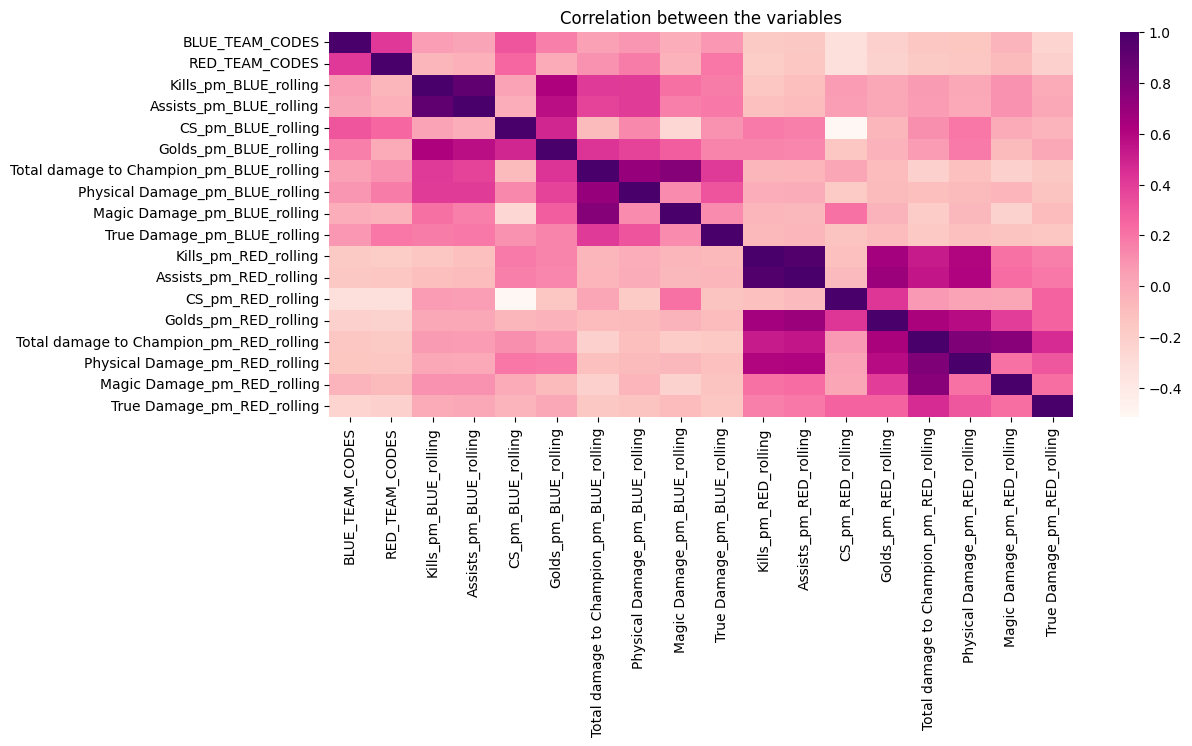

In [7]:
plt.subplots(figsize=(12,5))
game_correlation=game_data[predictors].corr()
sns.heatmap(game_correlation[predictors],annot=False,cmap='RdPu')
plt.title('Correlation between the variables')
plt.xticks(rotation=90)
plt.show()

In [8]:
X_train =  train[predictors]
y_train = train['BLUEWIN']

X_test = test[predictors]
y_test = test['BLUEWIN']


In [9]:
metrics = {'metric':['acc', 'prec']}
for model, name in list(zip(classifiers, classifier_names)):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    metrics[name] = [acc, prec] 


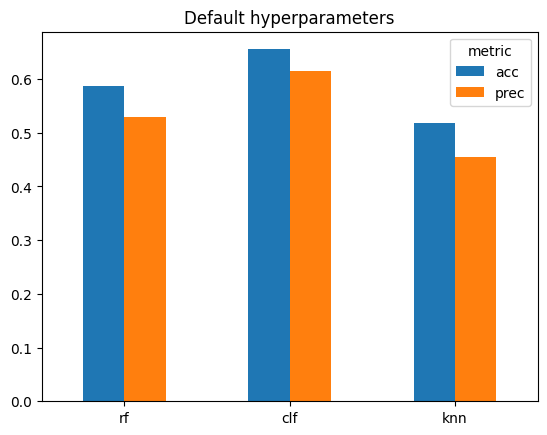

In [10]:
df = pd.DataFrame(metrics).set_index('metric').T
df.plot.bar(title='Default hyperparameters', rot=0)
plt.show()

# Hyperparameter tuning: RF
Here we look at some hyperparameter tuning for various models. We begin with RF.

In [11]:
%%time
# List Hyperparameters that we want to tune.
max_depth = list(np.arange(10,110,40))
min_samples_leaf = [1, 4]
min_samples_split = [2, 5]
n_estimators = list(np.arange(50,200,50))

# Convert to dictionary
hyperparameters = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators)

# Create new KNN object
rf_2 = RandomForestClassifier(random_state=42)

# Use GridSearch
GSCV = GridSearchCV(rf_2, hyperparameters)

# Fit the model
rf_best_model = GSCV.fit(X_train,y_train)

rf_best_max_depth = rf_best_model.best_estimator_.get_params()['max_depth']
rf_best_min_samples_leaf = rf_best_model.best_estimator_.get_params()['min_samples_leaf']
rf_best_min_samples_split = rf_best_model.best_estimator_.get_params()['min_samples_split']
rf_best_n_estimators = rf_best_model.best_estimator_.get_params()['n_estimators']

# Print The value of best Hyperparameters
print('Best max_depth:', rf_best_max_depth)
print('Best min_samples_leaf:', rf_best_min_samples_leaf)
print('Best min_samples_split:', rf_best_min_samples_split)
print('Best n_estimators:', rf_best_n_estimators)

Best max_depth: 10
Best min_samples_leaf: 1
Best min_samples_split: 5
Best n_estimators: 100
Wall time: 13.6 s


# Hyperparameter tuning: CLF
Here we look at some hyperparameter tuning for various models. We continue with CLF.

In [12]:
%%time
# List Hyperparameters that we want to tune.
max_leaf_nodes = [None]
min_samples_leaf = [1,2]

# Convert to dictionary
hyperparameters = dict(max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_samples_leaf)

# Create new KNN object
clf_2 = DecisionTreeClassifier(random_state=42)

# Use GridSearch
GSCV = GridSearchCV(clf_2, hyperparameters)

# Fit the model
clf_best_model = GSCV.fit(X_train,y_train)

# Save the best hyperparameters
clf_best_max_leaf_nodes = clf_best_model.best_estimator_.get_params()['max_leaf_nodes']
clf_best_min_samples_leaf = clf_best_model.best_estimator_.get_params()['min_samples_leaf']

# Print The value of best Hyperparameters
print('Best max_leaf_nodes:', clf_best_max_leaf_nodes)
print('Best min_samples_leaf:', clf_best_min_samples_leaf)

Best max_leaf_nodes: None
Best min_samples_leaf: 1
Wall time: 32.9 ms


# Hyperparameter tuning: KNN
Here we look at some hyperparameter tuning for various models. We continue with KNN.

In [13]:
%%time
# List Hyperparameters that we want to tune.
leaf_size = list(range(20,40, 5))
n_neighbors = list(range(3,20))
p=[1,2]

# Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

# Create new KNN object
knn_2 = KNeighborsClassifier()

# Use GridSearch
GSCV = GridSearchCV(knn_2, hyperparameters, scoring='accuracy', verbose=True)

# Fit the model
knn_best_model = GSCV.fit(X_train,y_train)

# Save the best hyperparameters
knn_best_leaf_size = knn_best_model.best_estimator_.get_params()['leaf_size']
knn_best_p = knn_best_model.best_estimator_.get_params()['p']
knn_best_n_neighbors = knn_best_model.best_estimator_.get_params()['n_neighbors']

# Print The value of best Hyperparameters
print('Best leaf_size:', knn_best_leaf_size)
print('Best p:', knn_best_p)
print('Best n_neighbors:', knn_best_n_neighbors)

Fitting 5 folds for each of 136 candidates, totalling 680 fits
Best leaf_size: 20
Best p: 2
Best n_neighbors: 5
Wall time: 1.8 s


# Comparing the optimised models
We now compare the optimised models to see which one performs best.

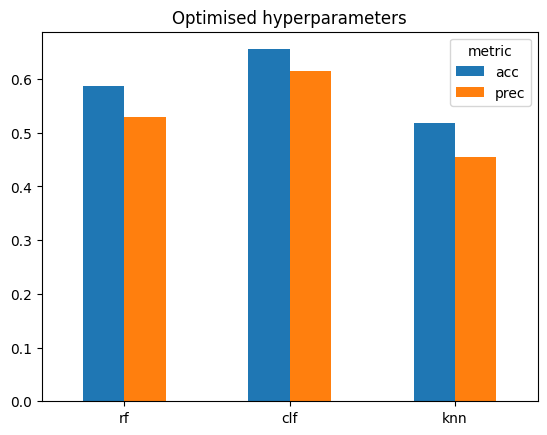

In [14]:

# Define the models
rf3 = RandomForestClassifier(max_depth=rf_best_max_depth, 
                             min_samples_leaf=rf_best_min_samples_leaf, 
                             min_samples_split=rf_best_min_samples_split, 
                             n_estimators=rf_best_n_estimators, 
                             random_state=42)

clf3 = DecisionTreeClassifier(max_leaf_nodes=clf_best_max_leaf_nodes, 
                              min_samples_leaf=clf_best_min_samples_leaf, 
                              random_state=42)

knn3 = KNeighborsClassifier(leaf_size=knn_best_leaf_size, 
                            n_neighbors=knn_best_n_neighbors, 
                            p=knn_best_p)

classifier_names3 = ['rf', 'clf', 'knn']
classifiers3 = [rf3, clf3, knn3]


metrics = {'metric':['acc', 'prec']}
for model, name in list(zip(classifiers3, classifier_names3)):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    metrics[name] = [acc, prec] 

df3 = pd.DataFrame(metrics).set_index('metric').T
df3.plot.bar(title='Optimised hyperparameters', rot=0)
plt.show()
    
    